In [1]:
#SINGLE LAYER PERCEPTRON

In [2]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
import sys

In [3]:
class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
    def _sigmoid(self, z):
        # expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2)\
                                + np.sum(w2[:, 1:] ** 2))
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum()\
                                + np.abs(w2[:, 1:]).sum())
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        return grad1, grad2
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        for i in range(self.epochs):
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            if print_progress:
                sys.stderr.write(
                    '\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_data = X_data[idx], y_data[idx]
            mini = np.array_split(range(
                y_data.shape[0]), self.minibatches)
            for idx in mini:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(
                    X[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)
                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)
                # update weights
                delta_w1, delta_w2 = self.eta * grad1,\
                self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self

In [5]:
data = pd.read_csv('C:/Users/PRIYANSHU SHARMA/Desktop/PRIYANSHU/6 STUDY/6 SEMSTER/MACHINE LEARNING/EXTRA/train1.csv')
data.head()

,1111,22.7,37.2,21,38,23.39,37.29,22.83285714,34.94285714,20.5,...,45.36,20.2,38.66333333,12.8,760.05,62,3.5,28,5.65,70
0,1112,21.500000,41.045000,20.500000,39.133333,22.926667,39.526667,21.7,34.126667,18.633333,...,34.663333,19.73,37.933333,8.47,764.166667,48.166667,8.000000,26.5,-1.92,210
1,1113,21.666667,38.000000,22.600000,35.700000,21.890000,36.590000,22.0,35.530000,19.000000,...,38.545000,19.79,39.430000,10.60,757.600000,57.000000,2.000000,27.0,2.40,50
2,1114,23.290000,38.530000,21.671429,38.000000,24.290000,36.200000,23.1,35.090000,22.042857,...,38.600000,22.60,36.194286,11.60,760.600000,63.000000,1.000000,40.0,4.67,50
3,1115,24.000000,42.560000,26.830000,34.356000,26.530000,40.333333,24.5,40.900000,21.500000,...,44.230000,22.60,44.090000,17.70,756.983333,63.000000,1.000000,21.5,10.40,250
4,1116,18.390000,43.363333,17.700000,42.433333,19.290000,42.500000,18.6,41.663333,17.200000,...,47.600000,16.70,46.000000,1.70,749.400000,97.000000,3.833333,32.5,1.25,180


In [6]:
colnames=['OBSERVATION', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'TEMP', 'PRE', 'RH_OUT', 'WS', 'V', 'TP', 'E']
data = pd.read_csv('C:/Users/PRIYANSHU SHARMA/Desktop/PRIYANSHU/6 STUDY/6 SEMSTER/MACHINE LEARNING/EXTRA/train1.csv', names=colnames, header=None)
data.head()

,OBSERVATION,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_8,T9,RH_9,TEMP,PRE,RH_OUT,WS,V,TP,E
0,1111,22.700000,37.200,21.000000,38.000000,23.390000,37.290000,22.832857,34.942857,20.500000,...,45.360000,20.20,38.663333,12.80,760.050000,62.000000,3.5,28.0,5.65,70
1,1112,21.500000,41.045,20.500000,39.133333,22.926667,39.526667,21.700000,34.126667,18.633333,...,34.663333,19.73,37.933333,8.47,764.166667,48.166667,8.0,26.5,-1.92,210
2,1113,21.666667,38.000,22.600000,35.700000,21.890000,36.590000,22.000000,35.530000,19.000000,...,38.545000,19.79,39.430000,10.60,757.600000,57.000000,2.0,27.0,2.40,50
3,1114,23.290000,38.530,21.671429,38.000000,24.290000,36.200000,23.100000,35.090000,22.042857,...,38.600000,22.60,36.194286,11.60,760.600000,63.000000,1.0,40.0,4.67,50
4,1115,24.000000,42.560,26.830000,34.356000,26.530000,40.333333,24.500000,40.900000,21.500000,...,44.230000,22.60,44.090000,17.70,756.983333,63.000000,1.0,21.5,10.40,250


In [7]:
data.head()

,OBSERVATION,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_8,T9,RH_9,TEMP,PRE,RH_OUT,WS,V,TP,E
0,1111,22.700000,37.200,21.000000,38.000000,23.390000,37.290000,22.832857,34.942857,20.500000,...,45.360000,20.20,38.663333,12.80,760.050000,62.000000,3.5,28.0,5.65,70
1,1112,21.500000,41.045,20.500000,39.133333,22.926667,39.526667,21.700000,34.126667,18.633333,...,34.663333,19.73,37.933333,8.47,764.166667,48.166667,8.0,26.5,-1.92,210
2,1113,21.666667,38.000,22.600000,35.700000,21.890000,36.590000,22.000000,35.530000,19.000000,...,38.545000,19.79,39.430000,10.60,757.600000,57.000000,2.0,27.0,2.40,50
3,1114,23.290000,38.530,21.671429,38.000000,24.290000,36.200000,23.100000,35.090000,22.042857,...,38.600000,22.60,36.194286,11.60,760.600000,63.000000,1.0,40.0,4.67,50
4,1115,24.000000,42.560,26.830000,34.356000,26.530000,40.333333,24.500000,40.900000,21.500000,...,44.230000,22.60,44.090000,17.70,756.983333,63.000000,1.0,21.5,10.40,250


In [8]:
print(data.columns)

Index(['OBSERVATION', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4',
       'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',
       'TEMP', 'PRE', 'RH_OUT', 'WS', 'V', 'TP', 'E'],
      dtype='object')


In [9]:
data.describe()

,OBSERVATION,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_8,T9,RH_9,TEMP,PRE,RH_OUT,WS,V,TP,E
count,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,...,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000,15780.000000
mean,9000.500000,21.683008,40.263077,20.339386,40.426604,22.265359,39.242550,20.853829,39.037623,19.591562,...,42.934090,19.489357,41.559527,7.414789,755.514104,79.756982,4.041824,38.378577,3.765539,97.294043
std,4555.437959,1.613157,3.983819,2.199896,4.085470,2.013391,3.247703,2.046331,4.337781,1.849086,...,5.223342,2.020488,4.135306,5.321081,7.385701,14.877160,2.447902,11.810273,4.202025,100.932234
min,1111.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,...,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,10.000000
25%,5055.750000,20.730000,37.360000,18.790000,37.890000,20.790000,36.900000,19.500000,35.530000,18.270000,...,39.066667,18.000000,38.530000,3.680000,750.933333,70.166667,2.000000,29.000000,0.900000,50.000000
50%,9000.500000,21.600000,39.663333,20.000000,40.500000,22.100000,38.560000,20.666667,38.433333,19.390000,...,42.376214,19.390000,40.900000,6.930000,756.100000,83.666667,3.666667,40.000000,3.470000,60.000000
75%,12945.250000,22.600000,43.090000,21.530000,43.290000,23.290000,41.760000,22.100000,42.193333,20.633333,...,46.560000,20.600000,44.363333,10.400000,760.900000,91.666667,5.500000,40.000000,6.550000,100.000000
max,16890.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.745000,...,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,850.000000


In [20]:
from sklearn.cross_validation import train_test_split
X = data.iloc[0:, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].values
X_train,X_test,Y_train,Y_test = train_test_split(X,data['E'], test_size=0.1, random_state=0)


In [21]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=25,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  shuffle=True,
                  minibatches=50,
                  random_state=1)

In [22]:
nn.fit(X_train, Y_train, print_progress=True)

IndexError: index 30 is out of bounds for axis 0 with size 10

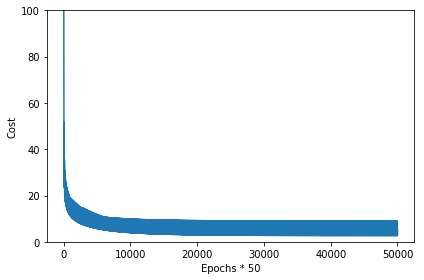

In [12]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 100])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

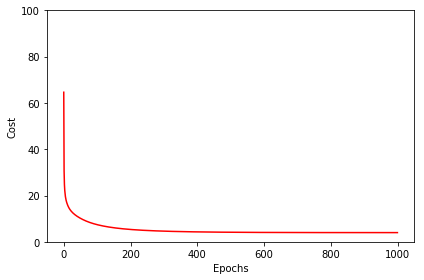

In [13]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)),
cost_avgs,
color='red')
plt.ylim([0, 100])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [14]:
Y_train_pred = nn.predict(X_train)
acc = np.sum(Y_train == Y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.96%


In [15]:
Y_test_pred = nn.predict(X_test)
acc = np.sum(Y_test == Y_test_pred, axis=0) / X_test.shape[0]
print('Testing accuracy: %.2f%%' % (acc * 100))

Testing accuracy: 93.81%
